In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau


sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD
from torch_model.dataset import ZzzPatchDataset
from torch_model.gru_model import ZzzTransformerGRUModule


PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))

2023-10-27 19:12:45.638567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 19:12:46.101407: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-27 19:12:47.495343: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

In [10]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
file = files[0]
df = pd.read_parquet(file)[22200: 22200 + 12*60*14]
df.head(1)

,series_id,step,timestamp,anglez,enmo,event,target,onset_target,wakeup_target
22200,c3072a759efb,22200,2018-02-27T19:05:00-0500,-19.8162,0.0403,None,1,0.0,0.0


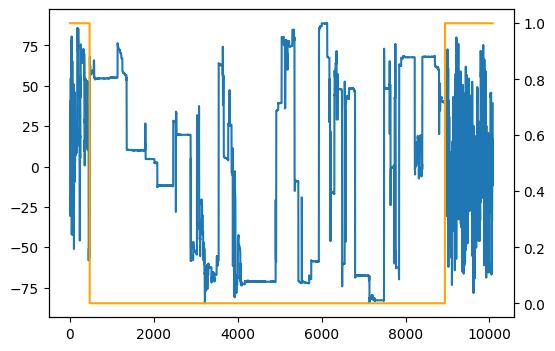

In [16]:
X = df["anglez"].values
y = df["target"].values

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(X)
ax2 = ax.twinx()
ax2.plot(y, c="orange")
plt.show()

In [14]:
class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, X: np.ndarray, y: np.ndarray=None):
        if self.always_apply:
            return self.apply(X, y)
        else:
            if np.random.rand() < self.p:
                return self.apply(X, y)
            else:
                return X, y

    def apply(self, X: np.ndarray, y: np.ndarray):
        raise NotImplementedError


class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, X: np.ndarray, y: np.ndarray=None):
        for trns in self.transforms:
            X, y = trns(X, y)
        return y


class OneOf:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, X: np.ndarray, y: np.ndarray=None):
        n_trns = len(self.transforms)
        trns_idx = np.random.choice(n_trns)
        trns = self.transforms[trns_idx]
        return trns(X, y)

## Gaussian Noise

In [15]:
class AddGaussianNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_noise_amplitude=0.5, **kwargs):
        super().__init__(always_apply, p)

        self.noise_amplitude = (0.0, max_noise_amplitude)

    def apply(self, X: np.ndarray, y: np.ndarray=None, **params):
        seq_len = X.shape[0]
        noise_amplitude = np.random.uniform(*self.noise_amplitude)
        noise = np.random.randn(seq_len) * noise_amplitude
        augmented = (X + noise).astype(y.dtype)
        return augmented, y

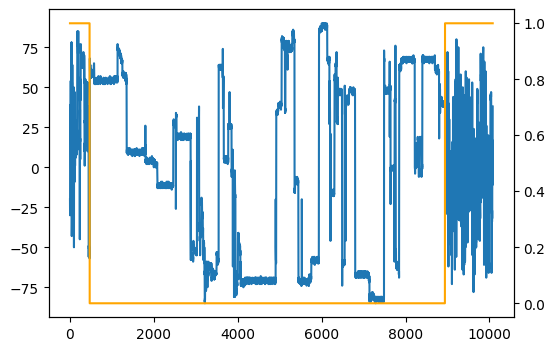

In [19]:
transform = AddGaussianNoise(always_apply=True, max_noise_amplitude=5)
X_aug, y_aug = transform(X, y)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(X_aug)
ax2 = ax.twinx()
ax2.plot(y_aug, c="orange")
plt.show()

## Accumulated Gaussian Noise

In [20]:
class AccumulatedGaussianNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_noise_amplitude=0.5, **kwargs):
        super().__init__(always_apply, p)

        self.noise_amplitude = (0.0, max_noise_amplitude)

    def apply(self, X: np.ndarray, y: np.ndarray=None, **params):
        seq_len = X.shape[0]
        noise_amplitude = np.random.uniform(*self.noise_amplitude)
        noise = np.random.randn(seq_len).cumsum() * noise_amplitude
        print(noise)
        augmented = (X + noise).astype(y.dtype)
        return augmented, y

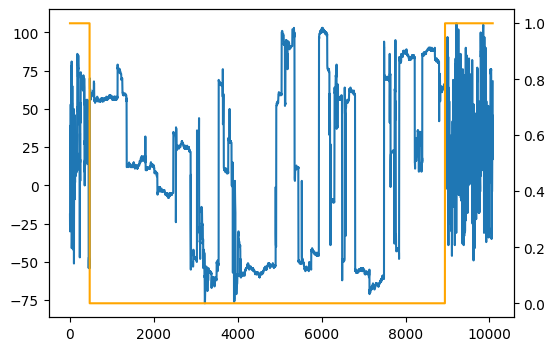

In [26]:
transform = AccumulatedGaussianNoise(always_apply=True, max_noise_amplitude=1)
X_aug, y_aug = transform(X, y)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(X_aug)
ax2 = ax.twinx()
ax2.plot(y_aug, c="orange")
plt.show()

## Copy & Paste

In [ ]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
file = files[0]

In [31]:
sleeping_dfs = []
awake_dfs = []

for file in tqdm(files):
    df = pd.read_parquet(file)

    df["phase"] = df["target"].diff().abs().fillna(0).cumsum()
    for _, phase_df in df.groupby("phase"):
        if phase_df["target"].mean() < 0.5:
            sleeping_dfs.append(phase_df)
        else:
            awake_dfs.append(phase_df)

100%|██████████| 277/277 [00:33<00:00,  8.20it/s]


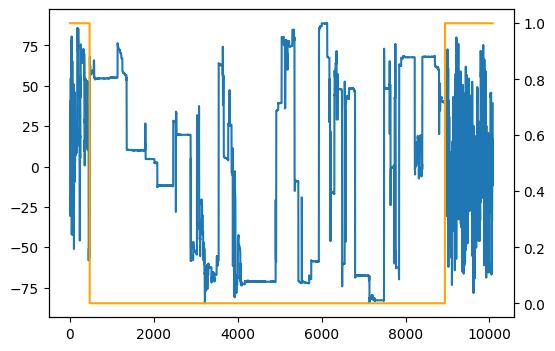

In [39]:
file = files[0]
df = pd.read_parquet(file)[22200: 22200 + 12*60*14].reset_index(drop=True)
df["phase"] = df["target"].diff().abs().fillna(0).cumsum()

X = df["anglez"].values
y = df["target"].values

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(X)
ax2 = ax.twinx()
ax2.plot(y, c="orange")
plt.show()

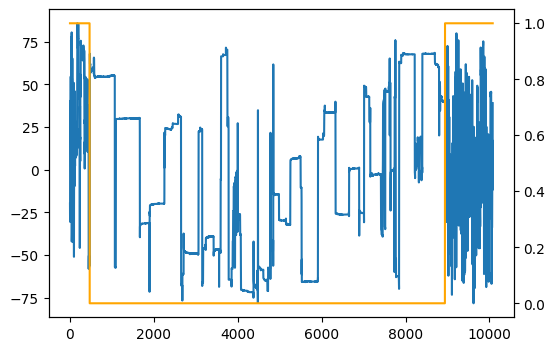

In [45]:
import random

X = df["anglez"].values
y = df["target"].values

for _, phase_df in df.groupby("phase"):
    if len(phase_df) < 12 * 120:
        continue

    # 切り取る長さ
    max_length = len(phase_df) - 12 * 30 * 2
    crop_length = random.randint(max_length // 8, max_length // 2)

    # 切り取る位置
    start = random.randint(12 * 30, len(phase_df) - 12 * 30 - crop_length - 1)
    end = start + crop_length

    if phase_df["target"].mean() < 0.5:
        df_idx = random.randint(0, len(sleeping_dfs) - 1)
        if sleeping_dfs[df_idx].shape[0] > crop_length + 12 * 30 * 2:
            start2 = random.randint(12 * 30, len(sleeping_dfs[df_idx]) - 12 * 30 - crop_length - 1)
            end2 = start2 + crop_length
            X[start: end] = sleeping_dfs[df_idx]["anglez"].values[start2: end2]
    else:
        df_idx = random.randint(0, len(awake_dfs) - 1)
        if awake_dfs[df_idx].shape[0] > crop_length + 12 * 30 * 2:
            start2 = random.randint(12 * 30, len(awake_dfs[df_idx]) - 12 * 30 - crop_length - 1)
            end2 = start2 + crop_length
            X[start: end] = awake_dfs[df_idx]["anglez"].values[start2: end2]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(X)
ax2 = ax.twinx()
ax2.plot(y, c="orange")
plt.show()